# MNIST VAE with enumeration of discrete latent variable

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import numpy as np
import os
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO #, TraceGraph_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD
from torchvision import utils
from matplotlib.pyplot import imshow
from torch.distributions import constraints

### Helper function

In [2]:
def show_batch(images,nrow=4,npadding=10):
    """Visualize a torch tensor of shape: (batch x ch x width x height) """
    batch, ch, width, height = images.shape
    if(images.device != "cpu"):
        images=images.cpu()
    grid = utils.make_grid(images,nrow, npadding, normalize=True, range=None, scale_each=True, pad_value=1)       
    imshow(grid.detach().numpy().transpose((1, 2, 0))) 
    
def train_one_epoch(svi, dataloader, verbose=False):
    epoch_loss = 0.
    n = 0
    for i, data in enumerate(dataloader, 0): #loop over minibatches
            
        # Get images and flatten them into vectors
        imgs,labels= data
        n += len(labels)
        if torch.cuda.is_available():
            imgs=imgs.cuda()
            
        loss = svi.step(imgs)
        
        if(verbose):
            print("i= %3d train_loss=%.5f" %(i,loss))
        epoch_loss += loss

    return epoch_loss / n

def evaluate_one_epoch(svi, dataloader, verbose=False):
    epoch_loss = 0.
    n = 0
    for i, data in enumerate(dataloader, 0): #loop over minibatches
            
        # Get images and flatten them into vectors
        imgs,labels= data
        n += len(labels)
        if torch.cuda.is_available():
            imgs=imgs.cuda()
        
        loss = svi.evaluate_loss(imgs)
        
        if(verbose):
            print("i= %3d  test_loss=%.5f" %(i,loss))
        epoch_loss += loss

    return epoch_loss / n

def save_obj(obj,root_dir,name):
    with open(root_dir + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(root_dir,name):
    with open(root_dir + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def save_model(model, root_dir, name):
    full_file_path= root_dir + name + '.pkl'
    torch.save(model.state_dict(),full_file_path)
    
def load_model(model, root_dir, name):
    full_file_path= root_dir + name + '.pkl'
    model.load_state_dict(torch.load(full_file_path))

### Define the simulation parameters

In [3]:
params = { 
    'K' : 10, #number of clusters
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28,
    'Z_DIM':2,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

{'K': 10, 'CHANNELS': 1, 'WIDTH': 28, 'HEIGHT': 28, 'Z_DIM': 2, 'use_cuda': True}


### Get the data

torch.Size([512, 1, 28, 28])


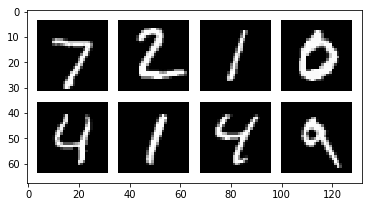

In [4]:
BATCH_SIZE = 512
kwargs = {'num_workers': 8, 'pin_memory': params["use_cuda"]}

trainset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs,labels = next(iter(testloader))

print(imgs.shape)
show_batch(imgs[:8],npadding=4)

### Define the VAE class

In [13]:
class ENCODER(torch.nn.Module):
    """ x -> p """
    
    def __init__(self, params):
        super().__init__()
        self.K      = params['K']
        self.ch     = params['CHANNELS']
        self.width  = params['WIDTH']
        self.height = params['HEIGHT']
        self.z_dim  = params['Z_DIM']
        self.x_dim = self.ch*self.width*self.height
        self.comp_p  = torch.nn.Sequential(
            torch.nn.Linear(self.x_dim,100, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(100,self.K, bias=True)
        )
            
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self,x):
        batch_size = x.shape[0]
        x1 = x.view(batch_size,-1)
        p = self.softmax(self.comp_p(x1))
        return p
    
class DECODER(torch.nn.Module):
    """ z -> x """
    
    def __init__(self, params):
        super().__init__()
        self.ch     = params['CHANNELS']
        self.width  = params['WIDTH']
        self.height = params['HEIGHT']
        self.z_dim  = params['Z_DIM']
        self.x_dim = self.ch*self.width*self.height
        
        self.comp_x_mu  = torch.nn.Linear(self.z_dim,self.x_dim, bias=True)
         
    def forward(self,z):
        batch_size = z.shape[0]
        x_mu = torch.sigmoid(self.comp_x_mu(z)).view(batch_size,self.ch,self.height,self.width)
        return x_mu
        


class VAE(torch.nn.Module):
    
    def __init__(self,params,encoder,decoder):
        super().__init__()
        
        # Parameters
        self.use_cuda = params['use_cuda']
        self.K      = params['K']
        self.ch     = params['CHANNELS']
        self.width  = params['WIDTH']
        self.height = params['HEIGHT']
        self.z_dim  = params['Z_DIM']
        self.x_dim = self.ch*self.width*self.height
        
        # Instantiate the encoder and decoder
        self.decoder = decoder
        self.encoder = encoder
        
        if(self.use_cuda):
            self.cuda()
        
    def guide(self, imgs=None):
        """ 1. run the inference to get: zwhere,zwhat
            2. sample latent variables 
        """       
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            imgs = torch.zeros(8,self.ch,self.height,self.width)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#

        batch_size,ch,width,height = imgs.shape
        pyro.module("encoder", self.encoder)

        # Global variables
        locs_mu = pyro.param("locs_mu",torch.randn((self.K,self.z_dim),device=imgs.device))
        locs_q = pyro.sample('locs', dist.Delta(locs_mu).to_event(2))
        
        scales_mu = pyro.param("scales_mu",imgs.new_ones(self.K,self.z_dim),constraint=constraints.positive)
        scales_q = pyro.sample('scales', dist.Delta(scales_mu).to_event(2))
        
        concentrations = pyro.param("concentrations",imgs.new_ones(self.K),constraint=constraints.positive)
        weights_q = pyro.sample('weights', dist.Dirichlet(concentrations))
        
        with pyro.plate('batch_size', batch_size, dim=-1):
            p = self.encoder(imgs)
            assignment = pyro.sample('assignment',dist.Categorical(p))
            z = pyro.sample('z_style', dist.Normal(locs_q[assignment], scales_q[assignment]).to_event(1))
        return p,z
            
    def model(self, imgs=None):
        """ 1. sample the latent from the prior:
                - z_type ~ Categorical(weights) 
                - z_style ~ N(loc,scale) 
            2. runs the generative model
            3. score the generative model against actual data 
        """
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            imgs = torch.zeros(8,self.ch,self.height,self.width)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#
            
        batch_size,ch,width,height = imgs.shape
        pyro.module("decoder", self.decoder)
        
        # Global variable
        weights = pyro.sample('weights', dist.Dirichlet(0.5 * imgs.new_ones(self.K)))
        locs = pyro.sample('locs', dist.Normal(0., 5.*imgs.new_ones(self.K,self.z_dim)).to_event(2))
        scales = pyro.sample('scales', dist.LogNormal(0., 0.25*imgs.new_ones(self.K,self.z_dim)).to_event(2))


        # Variable for each image
        with pyro.plate('batch_size', batch_size, dim=-1):
            assignment = pyro.sample('assignment', dist.Categorical(weights))
            z = pyro.sample('z_style', dist.Normal(locs[assignment], scales[assignment]).to_event(1))
            x_mu = self.decoder(z) #x_mu is between 0 and 1
            pyro.sample('obs', dist.Bernoulli(x_mu.view(-1,self.x_dim)).to_event(1), obs=imgs.view(-1,self.x_dim))
    


In [14]:
encoder = ENCODER(params)
decoder = DECODER(params)
vae = VAE(params,encoder,decoder)
vae.guide()
vae.model()

#load_model(vae,"/Users/ldalessi/ENUMERATION_MNIST/ARCHIVE/","vae_v5_10")

In [15]:
import pyro.poutine as poutine
#
print("----MODEL---------")
trace = poutine.trace(vae.model).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())
#
print("----GUIDE ---------")
trace = poutine.trace(vae.guide).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

----MODEL---------
             Trace Shapes:              
              Param Sites:              
decoder$$$comp_x_mu.weight 784   2      
  decoder$$$comp_x_mu.bias     784      
             Sample Sites:              
              weights dist       |  10  
                     value       |  10  
                  log_prob       |      
                 locs dist       |  10 2
                     value       |  10 2
                  log_prob       |      
               scales dist       |  10 2
                     value       |  10 2
                  log_prob       |      
           batch_size dist       |      
                     value   8   |      
                  log_prob       |      
           assignment dist   8   |      
                     value   8   |      
                  log_prob   8   |      
              z_style dist   8   |   2  
                     value   8   |   2  
                  log_prob   8   |      
                  obs dist   8   | 784

In [16]:
def test_model(model, guide, loss):
    pyro.clear_param_store()
    loss.loss(model, guide)
    
#with torch.autograd.set_detect_anomaly(True):
test_model(vae.model,vae.guide,Trace_ELBO())

In [17]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

TEST_FREQUENCY = 5
WRITE_FREQUENCY = 20
smoke_test= False
if(smoke_test):
    pyro.enable_validation(True)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 21
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 10001
    
    
# setup the optimizer
adam_args = {"lr": 1.0e-2}
#optimizer = Adamax(adam_args)
optimizer = Adadelta(adam_args)
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(num_particles=1))
loss_history = list()
min_loss = 999999

In [24]:
### Save the parameters beofre starting
#write_dir  = '/Users/ldalessi/ENUMERATION_MNIST/ARCHIVE/' 
write_dir  = '/home/ldalessi/VAE_MINST/ARCHIVE/' 
#load_model(vae,write_dir,"vae_v7_204")
name_vae  = "vae_v7_"
name_loss = "loss_history_v7_"
save_obj(params,write_dir,"params_model_v7")
dataloader = trainloader


# training loop
for epoch in range(190,10*NUM_EPOCHS):
    vae.train()    
    loss = train_one_epoch(svi, dataloader, verbose=(epoch==0))
    loss_history.append(loss)
    if(loss_history[-1] < min_loss):
        print("[epoch %03d] average loss: %.4f --New Record--" % (epoch, loss)) 
        min_loss = loss_history[-1]
        # Save if you got a record 
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(loss_history,write_dir,name_loss+str(epoch))
   
    elif((epoch % 20) == 0 or epoch < 4):
        
        print("[epoch %03d] average loss: %.4f" % (epoch, loss))
        # Save at the beginning and every 20 epochs
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(loss_history,write_dir,name_loss+str(epoch))
        
    else:
        print("[epoch %03d] average loss: %.4f" % (epoch, loss))

[epoch 190] average loss: 208.2795
[epoch 191] average loss: 208.1980
[epoch 192] average loss: 208.0905
[epoch 193] average loss: 208.1355
[epoch 194] average loss: 208.1610
[epoch 195] average loss: 208.0612
[epoch 196] average loss: 208.0942
[epoch 197] average loss: 208.1270
[epoch 198] average loss: 208.0592
[epoch 199] average loss: 208.0424
[epoch 200] average loss: 208.1045
[epoch 201] average loss: 208.0417
[epoch 202] average loss: 208.0730
[epoch 203] average loss: 208.0632
[epoch 204] average loss: 208.1321
[epoch 205] average loss: 208.0310
[epoch 206] average loss: 208.0166 --New Record--
[epoch 207] average loss: 208.0540
[epoch 208] average loss: 207.9435 --New Record--
[epoch 209] average loss: 208.0484
[epoch 210] average loss: 208.1545
[epoch 211] average loss: 208.0333
[epoch 212] average loss: 207.9426 --New Record--
[epoch 213] average loss: 207.9699
[epoch 214] average loss: 208.0017
[epoch 215] average loss: 207.9126 --New Record--
[epoch 216] average loss: 208.

[epoch 413] average loss: 206.9972
[epoch 414] average loss: 207.0638
[epoch 415] average loss: 206.9802
[epoch 416] average loss: 207.0500
[epoch 417] average loss: 206.9814
[epoch 418] average loss: 207.0155
[epoch 419] average loss: 206.7927 --New Record--
[epoch 420] average loss: 206.9011
[epoch 421] average loss: 206.8452
[epoch 422] average loss: 206.8341
[epoch 423] average loss: 206.8179
[epoch 424] average loss: 206.8648
[epoch 425] average loss: 206.7649 --New Record--
[epoch 426] average loss: 206.7576 --New Record--
[epoch 427] average loss: 206.7498 --New Record--
[epoch 428] average loss: 206.8216
[epoch 429] average loss: 206.7739
[epoch 430] average loss: 206.7600
[epoch 431] average loss: 206.7219 --New Record--
[epoch 432] average loss: 206.7398
[epoch 433] average loss: 206.6383 --New Record--
[epoch 434] average loss: 206.6808
[epoch 435] average loss: 206.6362 --New Record--
[epoch 436] average loss: 206.6278 --New Record--
[epoch 437] average loss: 206.4741 --New

[epoch 609] average loss: 201.1665
[epoch 610] average loss: 201.3211
[epoch 611] average loss: 201.2052
[epoch 612] average loss: 201.1134
[epoch 613] average loss: 201.2737
[epoch 614] average loss: 201.0279 --New Record--
[epoch 615] average loss: 200.9755 --New Record--
[epoch 616] average loss: 201.0310
[epoch 617] average loss: 201.0041
[epoch 618] average loss: 200.9751 --New Record--
[epoch 619] average loss: 201.0362
[epoch 620] average loss: 200.9583 --New Record--
[epoch 621] average loss: 200.9207 --New Record--
[epoch 622] average loss: 200.9868
[epoch 623] average loss: 200.9142 --New Record--
[epoch 624] average loss: 200.7925 --New Record--
[epoch 625] average loss: 200.7091 --New Record--
[epoch 626] average loss: 200.9351
[epoch 627] average loss: 200.6593 --New Record--
[epoch 628] average loss: 200.6961
[epoch 629] average loss: 200.5226 --New Record--
[epoch 630] average loss: 200.4448 --New Record--
[epoch 631] average loss: 200.6966
[epoch 632] average loss: 200.

[epoch 816] average loss: 198.2271
[epoch 817] average loss: 198.3059
[epoch 818] average loss: 198.1326 --New Record--
[epoch 819] average loss: 198.2684
[epoch 820] average loss: 198.1549
[epoch 821] average loss: 198.2628
[epoch 822] average loss: 198.1109 --New Record--
[epoch 823] average loss: 198.1850
[epoch 824] average loss: 198.2095
[epoch 825] average loss: 198.1839
[epoch 826] average loss: 198.1194
[epoch 827] average loss: 198.1008 --New Record--
[epoch 828] average loss: 198.1291
[epoch 829] average loss: 198.1517
[epoch 830] average loss: 198.1716
[epoch 831] average loss: 198.1455
[epoch 832] average loss: 198.1858
[epoch 833] average loss: 198.0335 --New Record--
[epoch 834] average loss: 198.0818
[epoch 835] average loss: 198.2690
[epoch 836] average loss: 198.1669
[epoch 837] average loss: 198.1227
[epoch 838] average loss: 198.1788
[epoch 839] average loss: 198.0494
[epoch 840] average loss: 198.1172
[epoch 841] average loss: 198.1515
[epoch 842] average loss: 198.

[epoch 1038] average loss: 197.4414
[epoch 1039] average loss: 197.4638
[epoch 1040] average loss: 197.4495
[epoch 1041] average loss: 197.4459
[epoch 1042] average loss: 197.4118
[epoch 1043] average loss: 197.4299
[epoch 1044] average loss: 197.4163
[epoch 1045] average loss: 197.4016
[epoch 1046] average loss: 197.3895
[epoch 1047] average loss: 197.4723
[epoch 1048] average loss: 197.4055
[epoch 1049] average loss: 197.3847
[epoch 1050] average loss: 197.4093
[epoch 1051] average loss: 197.4213
[epoch 1052] average loss: 197.4742
[epoch 1053] average loss: 197.5501
[epoch 1054] average loss: 197.5609
[epoch 1055] average loss: 197.4661
[epoch 1056] average loss: 197.4403
[epoch 1057] average loss: 197.5423
[epoch 1058] average loss: 197.4397
[epoch 1059] average loss: 197.4785
[epoch 1060] average loss: 197.4326
[epoch 1061] average loss: 197.4817
[epoch 1062] average loss: 197.4156
[epoch 1063] average loss: 197.4212
[epoch 1064] average loss: 197.3785
[epoch 1065] average loss: 1

[epoch 1259] average loss: 197.0535
[epoch 1260] average loss: 197.0232 --New Record--
[epoch 1261] average loss: 197.0881
[epoch 1262] average loss: 197.1315
[epoch 1263] average loss: 197.2202
[epoch 1264] average loss: 197.1058
[epoch 1265] average loss: 197.0880
[epoch 1266] average loss: 197.1353
[epoch 1267] average loss: 197.0746
[epoch 1268] average loss: 197.0603
[epoch 1269] average loss: 197.0695
[epoch 1270] average loss: 197.1279
[epoch 1271] average loss: 197.0733
[epoch 1272] average loss: 197.0529
[epoch 1273] average loss: 197.0995
[epoch 1274] average loss: 197.1013
[epoch 1275] average loss: 197.1396
[epoch 1276] average loss: 197.0415
[epoch 1277] average loss: 197.1017
[epoch 1278] average loss: 197.0155 --New Record--
[epoch 1279] average loss: 197.1159
[epoch 1280] average loss: 197.0922
[epoch 1281] average loss: 197.0623
[epoch 1282] average loss: 197.0768
[epoch 1283] average loss: 197.1470
[epoch 1284] average loss: 197.1196
[epoch 1285] average loss: 197.097

[epoch 1481] average loss: 196.8307
[epoch 1482] average loss: 196.8112
[epoch 1483] average loss: 196.8102
[epoch 1484] average loss: 196.8600
[epoch 1485] average loss: 196.8336
[epoch 1486] average loss: 196.8025
[epoch 1487] average loss: 196.8675
[epoch 1488] average loss: 196.8319
[epoch 1489] average loss: 196.8438
[epoch 1490] average loss: 196.8251
[epoch 1491] average loss: 196.8529
[epoch 1492] average loss: 196.8362
[epoch 1493] average loss: 196.7369 --New Record--
[epoch 1494] average loss: 196.8160
[epoch 1495] average loss: 196.8087
[epoch 1496] average loss: 196.8427
[epoch 1497] average loss: 196.8679
[epoch 1498] average loss: 196.8314
[epoch 1499] average loss: 196.8231
[epoch 1500] average loss: 196.8095
[epoch 1501] average loss: 196.8791
[epoch 1502] average loss: 196.8250
[epoch 1503] average loss: 196.8615
[epoch 1504] average loss: 196.8225
[epoch 1505] average loss: 196.8722
[epoch 1506] average loss: 196.7860
[epoch 1507] average loss: 196.7761
[epoch 1508] 

[epoch 1702] average loss: 196.6198
[epoch 1703] average loss: 196.5651
[epoch 1704] average loss: 196.5807
[epoch 1705] average loss: 196.5818
[epoch 1706] average loss: 196.5170 --New Record--
[epoch 1707] average loss: 196.5665
[epoch 1708] average loss: 196.6130
[epoch 1709] average loss: 196.5844
[epoch 1710] average loss: 196.5854
[epoch 1711] average loss: 196.5409
[epoch 1712] average loss: 196.5453
[epoch 1713] average loss: 196.5259
[epoch 1714] average loss: 196.6134
[epoch 1715] average loss: 196.6021
[epoch 1716] average loss: 196.6344
[epoch 1717] average loss: 196.5868
[epoch 1718] average loss: 196.6287
[epoch 1719] average loss: 196.5623
[epoch 1720] average loss: 196.5971
[epoch 1721] average loss: 196.6020
[epoch 1722] average loss: 196.5784
[epoch 1723] average loss: 196.6016
[epoch 1724] average loss: 196.5870
[epoch 1725] average loss: 196.6398
[epoch 1726] average loss: 196.5049 --New Record--
[epoch 1727] average loss: 196.5647
[epoch 1728] average loss: 196.558

[epoch 1918] average loss: 195.8303 --New Record--
[epoch 1919] average loss: 195.9382
[epoch 1920] average loss: 195.9115
[epoch 1921] average loss: 195.8976
[epoch 1922] average loss: 195.9061
[epoch 1923] average loss: 195.9980
[epoch 1924] average loss: 195.8788
[epoch 1925] average loss: 195.9504
[epoch 1926] average loss: 195.8747
[epoch 1927] average loss: 195.9113
[epoch 1928] average loss: 195.9180
[epoch 1929] average loss: 195.8974
[epoch 1930] average loss: 195.9222
[epoch 1931] average loss: 195.8587
[epoch 1932] average loss: 195.8884
[epoch 1933] average loss: 195.9508
[epoch 1934] average loss: 195.8236 --New Record--
[epoch 1935] average loss: 195.8308
[epoch 1936] average loss: 195.8168 --New Record--
[epoch 1937] average loss: 195.8200
[epoch 1938] average loss: 195.8609
[epoch 1939] average loss: 195.8139 --New Record--
[epoch 1940] average loss: 195.8597
[epoch 1941] average loss: 195.8166
[epoch 1942] average loss: 195.8727
[epoch 1943] average loss: 195.8484
[epo

[epoch 2134] average loss: 195.0623
[epoch 2135] average loss: 194.9961
[epoch 2136] average loss: 194.9635
[epoch 2137] average loss: 194.9679
[epoch 2138] average loss: 194.9887
[epoch 2139] average loss: 194.8959 --New Record--
[epoch 2140] average loss: 194.8975
[epoch 2141] average loss: 194.9140
[epoch 2142] average loss: 194.8355 --New Record--
[epoch 2143] average loss: 194.9088
[epoch 2144] average loss: 194.8153 --New Record--
[epoch 2145] average loss: 194.8131 --New Record--
[epoch 2146] average loss: 194.7312 --New Record--
[epoch 2147] average loss: 194.8252
[epoch 2148] average loss: 194.8049
[epoch 2149] average loss: 194.7594
[epoch 2150] average loss: 194.8207
[epoch 2151] average loss: 194.6698 --New Record--
[epoch 2152] average loss: 194.7708
[epoch 2153] average loss: 194.7843
[epoch 2154] average loss: 194.6584 --New Record--
[epoch 2155] average loss: 194.7535
[epoch 2156] average loss: 194.7295
[epoch 2157] average loss: 194.8628
[epoch 2158] average loss: 194.

[epoch 2341] average loss: 192.9914
[epoch 2342] average loss: 193.0812
[epoch 2343] average loss: 192.9876
[epoch 2344] average loss: 193.0253
[epoch 2345] average loss: 193.0547
[epoch 2346] average loss: 193.0138
[epoch 2347] average loss: 192.9798
[epoch 2348] average loss: 192.9950
[epoch 2349] average loss: 192.9002 --New Record--
[epoch 2350] average loss: 192.9329
[epoch 2351] average loss: 192.9242
[epoch 2352] average loss: 192.8529 --New Record--
[epoch 2353] average loss: 192.8850
[epoch 2354] average loss: 192.8450 --New Record--
[epoch 2355] average loss: 192.8965
[epoch 2356] average loss: 192.8408 --New Record--
[epoch 2357] average loss: 192.7748 --New Record--
[epoch 2358] average loss: 192.7787
[epoch 2359] average loss: 192.7790
[epoch 2360] average loss: 192.7153 --New Record--
[epoch 2361] average loss: 192.8297
[epoch 2362] average loss: 192.8275
[epoch 2363] average loss: 192.7895
[epoch 2364] average loss: 192.7524
[epoch 2365] average loss: 192.7912
[epoch 236

[epoch 2550] average loss: 191.3455
[epoch 2551] average loss: 191.3526
[epoch 2552] average loss: 191.3188
[epoch 2553] average loss: 191.3911
[epoch 2554] average loss: 191.3361
[epoch 2555] average loss: 191.2219
[epoch 2556] average loss: 191.2483
[epoch 2557] average loss: 191.3043
[epoch 2558] average loss: 191.3127
[epoch 2559] average loss: 191.2036 --New Record--
[epoch 2560] average loss: 191.1932 --New Record--
[epoch 2561] average loss: 191.2029
[epoch 2562] average loss: 191.2410
[epoch 2563] average loss: 191.1562 --New Record--
[epoch 2564] average loss: 191.1937
[epoch 2565] average loss: 191.1441 --New Record--
[epoch 2566] average loss: 191.1196 --New Record--
[epoch 2567] average loss: 191.0499 --New Record--
[epoch 2568] average loss: 191.1285
[epoch 2569] average loss: 191.1963
[epoch 2570] average loss: 191.0708
[epoch 2571] average loss: 191.1215
[epoch 2572] average loss: 191.1836
[epoch 2573] average loss: 191.1136
[epoch 2574] average loss: 191.1141
[epoch 257

[epoch 2756] average loss: 190.0691
[epoch 2757] average loss: 190.0075
[epoch 2758] average loss: 189.9825
[epoch 2759] average loss: 189.9804
[epoch 2760] average loss: 190.0020
[epoch 2761] average loss: 190.0209
[epoch 2762] average loss: 189.9379 --New Record--
[epoch 2763] average loss: 189.9318 --New Record--
[epoch 2764] average loss: 189.9525
[epoch 2765] average loss: 189.9399
[epoch 2766] average loss: 189.8863 --New Record--
[epoch 2767] average loss: 189.9914
[epoch 2768] average loss: 189.9524
[epoch 2769] average loss: 190.0216
[epoch 2770] average loss: 189.9790
[epoch 2771] average loss: 190.0719
[epoch 2772] average loss: 190.0450
[epoch 2773] average loss: 190.0368
[epoch 2774] average loss: 189.9479
[epoch 2775] average loss: 189.9179
[epoch 2776] average loss: 189.9634
[epoch 2777] average loss: 189.9330
[epoch 2778] average loss: 189.9173
[epoch 2779] average loss: 189.9675
[epoch 2780] average loss: 189.8947
[epoch 2781] average loss: 189.9013
[epoch 2782] averag

[epoch 2967] average loss: 189.0422
[epoch 2968] average loss: 189.0733
[epoch 2969] average loss: 189.0563
[epoch 2970] average loss: 189.0185
[epoch 2971] average loss: 189.0321
[epoch 2972] average loss: 189.0590
[epoch 2973] average loss: 189.0146
[epoch 2974] average loss: 189.0636
[epoch 2975] average loss: 189.1353
[epoch 2976] average loss: 189.0262
[epoch 2977] average loss: 189.0248
[epoch 2978] average loss: 189.0408
[epoch 2979] average loss: 189.0168
[epoch 2980] average loss: 189.0447
[epoch 2981] average loss: 189.0603
[epoch 2982] average loss: 189.0419
[epoch 2983] average loss: 189.0386
[epoch 2984] average loss: 188.9839 --New Record--
[epoch 2985] average loss: 189.1303
[epoch 2986] average loss: 189.1812
[epoch 2987] average loss: 189.2094
[epoch 2988] average loss: 189.1010
[epoch 2989] average loss: 189.0886
[epoch 2990] average loss: 189.0558
[epoch 2991] average loss: 189.0549
[epoch 2992] average loss: 189.0973
[epoch 2993] average loss: 189.0805
[epoch 2994] 

[epoch 3183] average loss: 188.4912
[epoch 3184] average loss: 188.4570
[epoch 3185] average loss: 188.4049 --New Record--
[epoch 3186] average loss: 188.4200
[epoch 3187] average loss: 188.4590
[epoch 3188] average loss: 188.3889 --New Record--
[epoch 3189] average loss: 188.3588 --New Record--
[epoch 3190] average loss: 188.4261
[epoch 3191] average loss: 188.3393 --New Record--
[epoch 3192] average loss: 188.3151 --New Record--
[epoch 3193] average loss: 188.3775
[epoch 3194] average loss: 188.3859
[epoch 3195] average loss: 188.3127 --New Record--
[epoch 3196] average loss: 188.4087
[epoch 3197] average loss: 188.3245
[epoch 3198] average loss: 188.3653
[epoch 3199] average loss: 188.3336
[epoch 3200] average loss: 188.3239
[epoch 3201] average loss: 188.2754 --New Record--
[epoch 3202] average loss: 188.3066
[epoch 3203] average loss: 188.2946
[epoch 3204] average loss: 188.3603
[epoch 3205] average loss: 188.3290
[epoch 3206] average loss: 188.3073
[epoch 3207] average loss: 188.

[epoch 3396] average loss: 187.6283
[epoch 3397] average loss: 187.5360 --New Record--
[epoch 3398] average loss: 187.5739
[epoch 3399] average loss: 187.5660
[epoch 3400] average loss: 187.5844
[epoch 3401] average loss: 187.5619
[epoch 3402] average loss: 187.6415
[epoch 3403] average loss: 187.5742
[epoch 3404] average loss: 187.5859
[epoch 3405] average loss: 187.6149
[epoch 3406] average loss: 187.5203 --New Record--
[epoch 3407] average loss: 187.6545
[epoch 3408] average loss: 187.5565
[epoch 3409] average loss: 187.6038
[epoch 3410] average loss: 187.5331
[epoch 3411] average loss: 187.5638
[epoch 3412] average loss: 187.5293
[epoch 3413] average loss: 187.5459
[epoch 3414] average loss: 187.5298
[epoch 3415] average loss: 187.4340 --New Record--
[epoch 3416] average loss: 187.5129
[epoch 3417] average loss: 187.5181
[epoch 3418] average loss: 187.5642
[epoch 3419] average loss: 187.5179
[epoch 3420] average loss: 187.4836
[epoch 3421] average loss: 187.4962
[epoch 3422] averag

[epoch 3612] average loss: 187.0155
[epoch 3613] average loss: 187.0192
[epoch 3614] average loss: 187.0366
[epoch 3615] average loss: 186.9984 --New Record--
[epoch 3616] average loss: 187.0071
[epoch 3617] average loss: 186.9544 --New Record--
[epoch 3618] average loss: 186.9754
[epoch 3619] average loss: 186.9596
[epoch 3620] average loss: 187.0183
[epoch 3621] average loss: 186.9735
[epoch 3622] average loss: 186.9989
[epoch 3623] average loss: 186.9555
[epoch 3624] average loss: 187.0503
[epoch 3625] average loss: 187.0094
[epoch 3626] average loss: 186.9299 --New Record--
[epoch 3627] average loss: 186.9549
[epoch 3628] average loss: 186.9175 --New Record--
[epoch 3629] average loss: 186.9935
[epoch 3630] average loss: 186.9734
[epoch 3631] average loss: 186.9926
[epoch 3632] average loss: 186.9717
[epoch 3633] average loss: 186.9664
[epoch 3634] average loss: 186.9305
[epoch 3635] average loss: 186.9511
[epoch 3636] average loss: 186.9240
[epoch 3637] average loss: 186.9337
[epo

[epoch 3833] average loss: 186.6878
[epoch 3834] average loss: 186.6980
[epoch 3835] average loss: 186.6610
[epoch 3836] average loss: 186.6657
[epoch 3837] average loss: 186.7177
[epoch 3838] average loss: 186.6376
[epoch 3839] average loss: 186.7069
[epoch 3840] average loss: 186.7239
[epoch 3841] average loss: 186.7203
[epoch 3842] average loss: 186.7090
[epoch 3843] average loss: 186.6525
[epoch 3844] average loss: 186.6843
[epoch 3845] average loss: 186.7122
[epoch 3846] average loss: 186.6455
[epoch 3847] average loss: 186.7141
[epoch 3848] average loss: 186.7110
[epoch 3849] average loss: 186.6993
[epoch 3850] average loss: 186.6821
[epoch 3851] average loss: 186.6921
[epoch 3852] average loss: 186.6383
[epoch 3853] average loss: 186.7115
[epoch 3854] average loss: 186.6492
[epoch 3855] average loss: 186.6154 --New Record--
[epoch 3856] average loss: 186.6157
[epoch 3857] average loss: 186.5800 --New Record--
[epoch 3858] average loss: 186.6415
[epoch 3859] average loss: 186.632

Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=L size=28x28 at 0x7F77DC74E128>>
Traceback (most recent call last):
  File "/home/ldalessi/anaconda3/envs/pyro/lib/python3.6/site-packages/PIL/Image.py", line 600, in __del__
    if (hasattr(self, 'fp') and hasattr(self, '_exclusive_fp')
KeyboardInterrupt


KeyboardInterrupt: 

<class 'numpy.ndarray'>


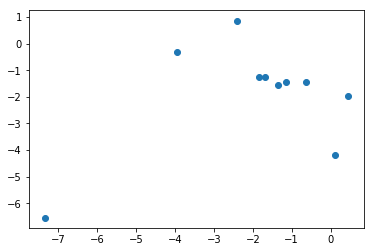

In [25]:
x = pyro.param('locs_mu')
x = x.detach().cpu().numpy()
print(type(x))
plt.scatter(x[:,0],x[:,1])

In [26]:
print(pyro.param('locs_mu'))
print(pyro.param('scales_mu'))
print(pyro.param('concentrations'))

#.detach().numpy().item()
#learned_beta = pyro.param('beta').detach().numpy().item()

tensor([[-7.3541, -6.5381],
        [-1.1430, -1.4556],
        [ 0.4500, -1.9841],
        [-1.6827, -1.2674],
        [-2.4079,  0.8634],
        [-3.9594, -0.3218],
        [ 0.1102, -4.1803],
        [-0.6292, -1.4616],
        [-1.3562, -1.5735],
        [-1.8432, -1.2480]], device='cuda:0', requires_grad=True)
tensor([[0.3560, 0.3768],
        [0.4256, 0.3943],
        [0.1801, 0.1808],
        [0.4121, 0.3754],
        [0.1416, 0.1098],
        [0.1755, 0.1346],
        [0.1912, 0.2214],
        [0.5821, 0.5526],
        [0.5519, 0.5183],
        [0.5130, 0.4674]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.2883, 0.3684, 0.5221, 0.3681, 2.8729, 4.6298, 3.2252, 0.1838, 0.2388,
        0.2744], device='cuda:0', grad_fn=<AddBackward0>)
